### T-frames as mini batch
Try to consider T-frames as a mini batch, which means return ground truth for each frame.  

In [1]:
import os
import json
import torch
import random
import cv2
import math
import numpy as np
import torchvision
from pathlib import Path
from torch import nn
from torch import optim
import torch.utils.data as Data
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pad_sequence
from torch.nn import functional as F
from torchvision import models, transforms
import matplotlib.pyplot as plt 
import matplotlib
import tqdm
from sklearn.metrics import jaccard_score

%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
data_path = Path("C:/Users/Siyao/Downloads/EndoVis2017Data")
train_path = data_path / "cropped_train"

def get_split(fold):
    """Split train and valid dataset based on the No. of folder"""
    folds = {0: [1, 3],
             1: [2, 5],
             2: [4, 8],
             3: [6, 7]}
    train_path = data_path / 'cropped_train'

    train_file_names = []
    val_file_names = []

    for instrument_id in range(1, 9):
        if instrument_id in folds[fold]:
            val_file_names += list((train_path / ('instrument_dataset_' + str(instrument_id)) / 'images').glob('*'))
        else:
            train_file_names += list((train_path / ('instrument_dataset_' + str(instrument_id)) / 'images').glob('*'))

    return train_file_names, val_file_names

train_file_names, val_file_names = get_split(0)

def load_image(path):
    img = cv2.imread(str(path))
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

binary_factor = 255
parts_factor = 85
instrument_factor = 32

def load_mask(path, problem_type="binary", mask_folder="instruments_masks",factor=instrument_factor):
    if problem_type == 'binary':
        mask_folder = 'binary_masks'
        factor = binary_factor
    elif problem_type == 'parts':
        mask_folder = 'parts_masks'
        factor = parts_factor
    elif problem_type == 'instruments':
        factor = instrument_factor
        mask_folder = 'instruments_masks'

    mask = cv2.imread(str(path).replace('images', mask_folder).replace('jpg', 'png'), 0)

    return (mask / factor).astype(np.uint8)

In [3]:
tau = 1
train_img_path = [str(i) for i in train_file_names]
train_frame_name = [i for i in train_img_path if int(i[-7:-4])>=tau]
valid_img_path = [str(i) for i in val_file_names] 
valid_frame_name = [i for i in valid_img_path if int(i[-7:-4])>=tau]

class InstrumentDataset(Dataset):
    """Dataset that loads multiple frame"""

    def __init__(self, file_names, problem_type="binary", tau=5):
        self.file_names = file_names
        self.problem_type = problem_type
        self.tau = tau      # tau is the number of frames should be combiend
        self.transform = transforms.Compose([
                                transforms.ToPILImage(),
                                transforms.Resize([256,320]),
                                transforms.ToTensor()
                            ]) 
    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        current_frame = self.file_names[idx]
        # mask = load_mask(current_frame, self.problem_type)
        # mask = self.transform(mask)
        frames_ls = []
        masks_ls = []
        for i in range(tau):
            to_find = "frame"+current_frame[-7:-4]
            to_repl = "frame"+ '%03d' % (int(current_frame[-7:-4])-i)
            frame = current_frame.replace(to_find, to_repl)
            frame_array = load_image(frame)
            frame_tensor = self.transform(frame_array)
            mask_array = load_mask(frame)
            mask_tensor = self.transform(mask_array)
            # Change the value in mask to 1 - 0 
            mask_tensor = torch.where(mask_tensor>0,1,0)
            # frame_tensor = torch.from_numpy(frame_tensor)            
            frames_ls.append(frame_tensor)
            masks_ls.append(mask_tensor)
        frames_stack = torch.stack(frames_ls, 0)
        masks_stack = torch.stack(masks_ls, 0)
        # permute the tensor from [tau, H, W, C] to [tau, C, H, W]
        # frames_tensor = frames_stack.permute(0,3,1,2) 
        return frames_stack.float(), masks_stack.float(), str(current_frame)

In [4]:
training_data_frames = InstrumentDataset(train_frame_name,tau=tau)
valid_data_frames = InstrumentDataset(valid_frame_name,tau=tau)

batch_size = 1
training_data_loader = Data.DataLoader(training_data_frames, batch_size=batch_size, shuffle=True)
valid_data_loader = Data.DataLoader(valid_data_frames, batch_size=batch_size, shuffle=False)

In [5]:
a,b,c = next(iter(training_data_loader))
print(f"Data shape: {a.shape}")
print(f"Mask shape: {b.shape}")
print(f"Path: {c}")
# img = a[0][0].permute(1,2,0)
# plt.imshow(img)

Data shape: torch.Size([1, 1, 3, 256, 320])
Mask shape: torch.Size([1, 1, 1, 256, 320])
Path: ('C:\\Users\\Siyao\\Downloads\\EndoVis2017Data\\cropped_train\\instrument_dataset_6\\images\\frame022.jpg',)


## Model

In [6]:
class CNNBackbone(nn.Module):
    def __init__(self, model="resnet101", pretrained=True):
        super(CNNBackbone, self).__init__()
        self.model_name = model
        self.pretrained = pretrained
        if self.model_name == "resnet101" and pretrained:
            model = models.resnet101(pretrained=True)
            self.cnn = torch.nn.Sequential(*(list(model.children())[:-3])).eval()
        else:
            raise NotImplementedError("Please use some pretrained CNN models")
        for param in self.cnn.parameters():
            param.requires_grad = False
        
    def forward(self, x):
        y = self.cnn(x[0])
        out = y.unsqueeze(0)
        # out.shape = [batch_size, T, C, H, W] = [1, T, 1024, 16, 20]
        return out

In [7]:
class PositionalEncoding3D(nn.Module):
    """https://github.com/tatp22/multidim-positional-encoding/blob/master/positional_encodings/positional_encodings.py"""
    
    def __init__(self, channels=1024):
        super(PositionalEncoding3D, self).__init__()
        channels = int(np.ceil(channels/6)*2)
        if channels % 2:
            channels += 1
        self.channels = channels
        inv_freq = 1. / (10000 ** (torch.arange(0, channels, 2).float() / channels))
        self.register_buffer('inv_freq', inv_freq)

    def forward(self, tensor):
        # Input tensor shape: [batch_size, T, C, H, W] 
        """
        :param tensor: A 5d tensor of size (batch_size, x, y, z, ch)
        :return: Positional Encoding Matrix of size (batch_size, x, y, z, ch)
        """
        tensor = tensor.permute(0, 4, 3, 1, 2)
        if len(tensor.shape) != 5:
            raise RuntimeError("The input tensor has to be 5d!")

        batch_size, x, y, z, orig_ch = tensor.shape
        pos_x = torch.arange(x, device=tensor.device).type(self.inv_freq.type())
        pos_y = torch.arange(y, device=tensor.device).type(self.inv_freq.type())
        pos_z = torch.arange(z, device=tensor.device).type(self.inv_freq.type())
        sin_inp_x = torch.einsum("i,j->ij", pos_x, self.inv_freq)
        sin_inp_y = torch.einsum("i,j->ij", pos_y, self.inv_freq)
        sin_inp_z = torch.einsum("i,j->ij", pos_z, self.inv_freq)
        emb_x = torch.cat((sin_inp_x.sin(), sin_inp_x.cos()), dim=-1).unsqueeze(1).unsqueeze(1)
        emb_y = torch.cat((sin_inp_y.sin(), sin_inp_y.cos()), dim=-1).unsqueeze(1)
        emb_z = torch.cat((sin_inp_z.sin(), sin_inp_z.cos()), dim=-1)
        emb = torch.zeros((x,y,z,self.channels*3),device=tensor.device).type(tensor.type())
        emb[:,:,:,:self.channels] = emb_x
        emb[:,:,:,self.channels:2*self.channels] = emb_y
        emb[:,:,:,2*self.channels:] = emb_z
        out = emb[None,:,:,:,:orig_ch].repeat(batch_size, 1, 1, 1, 1)
        out = out.permute(0, 3, 4, 2, 1)
        return out

In [8]:
class SparseAttention(nn.Module):
    """Sparse Self Attention Module"""
    def __init__(self, in_dim=1024):
        """The only iuput attribute is dimension"""
        super(SparseAttention, self).__init__()
        self.query_conv = nn.Conv3d(in_channels=in_dim, out_channels=in_dim//8, kernel_size=1)
        self.key_conv = nn.Conv3d(in_channels=in_dim, out_channels=in_dim//8, kernel_size=1)
        self.value_conv = nn.Conv3d(in_channels=in_dim, out_channels=in_dim, kernel_size=1)
        self.softmax = nn.Softmax(dim=4)
        self.gamma = nn.Parameter(torch.zeros(1))
        self.affinity = torch.zeros(0)

    def forward(self, x):
        # Input tensor shape: [batch_size, T, channel, H, W] 
        # Permute x to : [batch_size, channel, H, W, T]
        x = x.permute(0, 2, 3, 4, 1)
        b, C, H, W, T = x.shape
        proj_query = self.query_conv(x)
        proj_query_H = proj_query.permute(0,3,4,1,2).contiguous().view(b*W*T,-1,H).permute(0,2,1) # [b*W*T,H,C]
        proj_query_W = proj_query.permute(0,2,4,1,3).contiguous().view(b*H*T,-1,W).permute(0,2,1) # [b*H*T,W,C]
        proj_query_T = proj_query.permute(0,2,3,1,4).contiguous().view(b*W*H,-1,T).permute(0,2,1) # [b*W*H,T,C]

        proj_key = self.key_conv(x)
        proj_key_H = proj_key.permute(0,3,4,1,2).contiguous().view(b*W*T,-1,H)      # [b*W*T,C,H]
        proj_key_W = proj_key.permute(0,2,4,1,3).contiguous().view(b*H*T,-1,W)      # [b*H*T,C,W]
        proj_key_T = proj_key.permute(0,2,3,1,4).contiguous().view(b*W*H,-1,T)      # [b*W*H,C,T]

        proj_value = self.value_conv(x)
        proj_value_H = proj_value.permute(0,3,4,1,2).contiguous().view(b*W*T,-1,H)      # [b*W*T,C,H]
        proj_value_W = proj_value.permute(0,2,4,1,3).contiguous().view(b*H*T,-1,W)      # [b*H*T,C,W]
        proj_value_T = proj_value.permute(0,2,3,1,4).contiguous().view(b*W*H,-1,T)      # [b*W*H,C,T]

        energy_H = torch.bmm(proj_query_H, proj_key_H).view(b,W,T,H,H).permute(0,3,1,2,4) # [b,H,W,T,H]
        energy_W = torch.bmm(proj_query_W, proj_key_W).view(b,H,T,W,W).permute(0,1,3,2,4) # [b,H,W,T,W]
        energy_T = torch.bmm(proj_query_T, proj_key_T).view(b,H,W,T,T)                    # [b,H,W,T,T]
        score = self.softmax(torch.cat([energy_H,energy_W,energy_T],4))         # [b,H,W,T,(H+W+T)]
        affinity = torch.max(score, 4).values
        self.affinity = affinity.permute(0,3,1,2)
        
        att_H = score[:,:,:,:,0:H].permute(0,2,3,1,4).contiguous().view(b*W*T,H,H)      # [b*W*T,H,H]
        att_W = score[:,:,:,:,H:H+W].permute(0,1,4,2,3).contiguous().view(b*H*T,W,W)    # [b*H*T,W,W]
        att_T = score[:,:,:,:,H+W:].contiguous().view(b*H*W,T,T)                        # [b*H*W,T,T]

        out_H = torch.bmm(proj_value_H, att_H.permute(0,2,1)).view(b,W,T,-1,H).permute(0,3,4,1,2)
        out_W = torch.bmm(proj_value_W, att_W.permute(0,2,1)).view(b,H,T,-1,W).permute(0,3,1,4,2)
        out_T = torch.bmm(proj_value_T, att_T.permute(0,2,1)).view(b,H,W,-1,T).permute(0,3,1,2,4)
        
        # permute back to [batch_size, T, channel, H, W] 
        output = self.gamma*(out_H + out_T + out_W).permute(0,4,1,2,3)

        return output

In [9]:
class SSTEncoder(nn.Module):
    """Define the Multi-head attention -> Add&Norm -> Feed Forward -> Add&Norm module"""
    def __init__(self, dim=1024, dropout=0.2):
        super(SSTEncoder, self).__init__()

        # Multi-head attention sub-layer
        self.attn = SparseAttention(dim)
        self.norm_1 = nn.LayerNorm(dim)
        
        # Feed forward sub-layer
        self.fc = nn.Sequential(
            nn.Linear(in_features=dim, out_features=dim*2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(in_features=dim*2, out_features=dim)
        )
        self.norm_2 =  nn.LayerNorm(dim)
    
    def forward(self, x):
        y1 = self.attn(x)
        x2 = (x+y1).permute(0,3,4,1,2)   # permute from [b,T,C,H,W] to [b,H,W,T,C]
        y2 = self.norm_1(x2)
        y3 = self.fc(y2)
        out = self.norm_2(y2+y3).permute(0,3,4,1,2)  # permute from [b,H,W,T,C] to [b,T,C,H,W]

        return out

In [10]:
class DecoderBlock(nn.Module):
    """Define Decoder block for deconvolution"""
    def __init__(self, in_channels, mid_channels, out_channels, deconv=True):
        super(DecoderBlock, self).__init__()
        self.in_channels = in_channels
        if deconv:
            self.Deblock = nn.Sequential(
                nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.ConvTranspose2d(mid_channels, out_channels, kernel_size=4, stride=2, padding=1)
                
            )
        else:
            self.Deblock = nn.Sequential(
                nn.Upsample(scale_factor=2, mode='bilinar'),
                nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
                nn.ReLU(),
            )
    
    def forward(self, x):
        x = x.squeeze(0)
        y = self.Deblock(x)
        y = y.unsqueeze(0)
        return y

In [13]:
class MyTransformer(nn.Module):
    def __init__(self, num_layers=4):
        super(MyTransformer, self).__init__()

        self.backbone = CNNBackbone()
        self.pos_encoding = PositionalEncoding3D()
        self.self_attn1 = SSTEncoder()
        self.self_attn2 = SSTEncoder()
        self.self_attn3 = SSTEncoder()
        self.self_attn4 = SSTEncoder()
        self.dec1 = DecoderBlock(1024*2+4,1024*2+4,512)
        self.dec2 = DecoderBlock(512,1024,256)
        self.dec3 = DecoderBlock(256,512,128)
        self.dec4 = DecoderBlock(128,256,1)
        # self.object_affinity = torch.cat([self.self_attn1.attn.affinity,
        #                                   self.self_attn2.attn.affinity,
        #                                   self.self_attn3.attn.affinity,
        #                                   self.self_attn4.attn.affinity], 0)]
        self.cnn_feat = torch.zeros(1)
        self.encod_feat = torch.zeros(1)
        self.obj_aff = torch.zeros(1)

    def forward(self, x):
        # 1. subtract feature embedding from CNN backbone [b,T,C,H',W']
        cnn_fs = self.backbone(x)
        self.cnn_feat = cnn_fs
        # Get positional encoding and add it to the feature embedding
        pe = self.pos_encoding(cnn_fs)
        y = pe + cnn_fs

        # 2. Encoded feature from transformer layers 
        y = self.self_attn1(y)
        y = self.self_attn2(y)
        y = self.self_attn3(y)
        T_L = self.self_attn4(y)
        self.encod_feat = T_L
        
        # 3. Object Affinity Value [N_layers,T,H',W']:
        obj_aff = torch.cat([self.self_attn1.attn.affinity,
                                          self.self_attn2.attn.affinity,
                                          self.self_attn3.attn.affinity,
                                          self.self_attn4.attn.affinity], 0)

        # Adjust to [b,T,C,H',W']
        obj_aff = obj_aff.transpose(0,1).unsqueeze(0)
        self.obj_aff = obj_aff

        # Concatnate feature together
        emb = torch.cat([cnn_fs, T_L, obj_aff],dim=2)
        # print(y.shape,T_L.shape,obj_aff.shape)
        
        z = self.dec1(emb)
        z = self.dec2(z)
        z = self.dec3(z)
        z = self.dec4(z)
        
        return z

In [14]:
model = MyTransformer()
model = model.to(device)
z = model(a.to(device))
z.shape

torch.Size([1, 1, 1, 256, 320])

In [13]:
# Decoder = DecoderBlock(2052,1024,1)
# Decoder.to(device)
# zd1 = Decoder(z)
# z.shape, zd1.shape

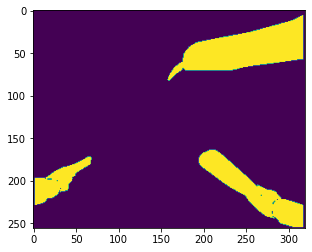

In [15]:
img = b[0][0].permute(1,2,0)
plt.imshow(img)

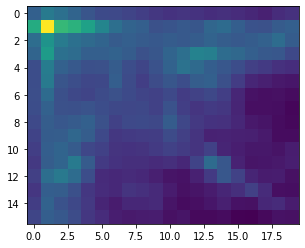

In [17]:
img = (model.pos_encoding(model.cnn_feat)+model.cnn_feat)[0][0].detach().cpu().permute(1,2,0)
img = torch.sum(img, 2)
plt.imshow(img)

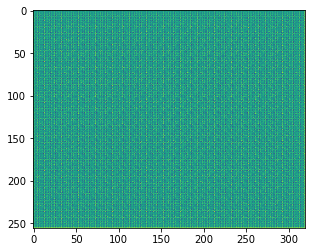

In [18]:
z0 = z.cpu().detach()
img = z0[0][0].permute(1,2,0)
plt.imshow(img)

In [19]:
z0.shape, b.shape

(torch.Size([1, 1, 1, 256, 320]), torch.Size([1, 1, 1, 256, 320]))

### Loss Function and Criterion

In [21]:
class LossBinary:
    """
    Loss defined as \alpha BCE - (1 - \alpha) SoftJaccard
    """

    def __init__(self, jaccard_weight=0):
        self.nll_loss = nn.BCEWithLogitsLoss()
        self.jaccard_weight = jaccard_weight

    def __call__(self, outputs, targets):
        loss = (1 - self.jaccard_weight) * self.nll_loss(outputs, targets)

        if self.jaccard_weight:
            eps = 1e-15
            jaccard_target = (targets == 1).float()
            jaccard_output = torch.sigmoid(outputs)

            intersection = (jaccard_output * jaccard_target).sum()
            union = jaccard_output.sum() + jaccard_target.sum()

            loss -= self.jaccard_weight * torch.log((intersection + eps) / (union - intersection + eps))
        return loss

In [22]:
def train(model, train_dataloader, valid_dataloader, criterion, optimizer, epochs):
    # Initialize lists to store loss and fscore each epoch
    LOSS_train = []
    LOSS_valid = []
    IOU_train = []
    IOU_valid = []  

    for epoch in tqdm.trange(epochs, desc="Epochs"):
        result = []
        train_loss = 0.0
        train_IOU = 0.0
        valid_loss = 0.0
        valid_IOU = 0.0
        # Begin training
        model.train()
        for data, mask, _ in train_dataloader:
            data, mask = data.to(device), mask.to(device)

            output = model(data)                            # Forward Passing
            # output = output[0][0].unsqueeze(0)
            loss = criterion(output, mask)                  # Compute loss
            # preds = torch.sigmoid(output) > 0.5             # Make prediction
            # preds = preds.to(torch.float32)                 # Convert to float32 torch
            loss.backward()                                 # Compute gradients
            optimizer.step()                                # Update the model parameters
            # scheduler.step()                                # Update learning rate with scheduler
            optimizer.zero_grad()                           # Clear the gradients
            train_loss += loss.item() * data.size(0)        # Compute training loss

            
            # train_IOU += get_jaccard(mask.to("cpu").to(torch.float16).numpy(), 
            #                      preds.to("cpu").to(torch.float16).numpy()) * data.size(0)

        # Begin validation
        model.eval()
        for data, mask, _ in valid_dataloader:
            data, mask = data.to(device), mask.to(device)

            output = model(data)                            # Forward Passing
            # output = output[0][0].unsqueeze(0)
        
            loss = criterion(output, mask)                  # Compute loss
            # preds = torch.sigmoid(output) > 0.5             # Make prediction
            # preds = preds.to(torch.float32)                 # Convert to float32 torch
            valid_loss += loss.item() * data.size(0)        # Compute validation loss
            # valid_IOU += get_jaccard(mask.to("cpu").to(torch.float16).numpy(), 
            #                      preds.to("cpu").to(torch.float16).numpy()) * data.size(0)
        
        # Compute epoch loss and f1
        epoch_train_loss = train_loss / len(train_dataloader.dataset)
        # epoch_train_IoU = train_IOU / len(train_dataloader.dataset)
        epoch_valid_loss = valid_loss / len(valid_dataloader.dataset)
        # epoch_valid_IoU = valid_IOU / len(valid_dataloader.dataset)

        # Record epoch loss and f1 to the list
        LOSS_train.append(epoch_train_loss)
        LOSS_valid.append(epoch_valid_loss)
        # IOU_train.append(epoch_train_IoU)
        # IOU_valid.append(epoch_valid_IoU)       

        # result.append(f'{epoch} TRAIN loss: {epoch_train_loss:.4f}, IOU: {epoch_train_IoU:.4f}   VALID loss: {epoch_valid_loss:.4f}, IOU: {epoch_valid_IoU:.4f}')
        result.append(f'{epoch} TRAIN loss: {epoch_train_loss:.4f}, VALID loss: {epoch_valid_loss:.4f}, ')


        print(result)
    return LOSS_train, LOSS_valid, IOU_train, IOU_valid

In [23]:
criterion = LossBinary(1)
# criterion = criterion.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)
LOSS_train, LOSS_valid, FSCORE_train, FSCORE_valid = train(model, training_data_loader, valid_data_loader, criterion, optimizer, epochs=1)

Epochs: 100%|██████████| 1/1 [02:17<00:00, 137.01s/it]

['0 TRAIN loss: 2.9006, VALID loss: 2.1494, ']


In [24]:
frame,mask,c = next(iter(training_data_loader))
print(f"Data shape: {frame.shape}")
print(f"Mask shape: {mask.shape}")
print(f"Path: {c}")
# img = a[0][0].permute(1,2,0)
# plt.imshow(img)

Data shape: torch.Size([1, 1, 3, 256, 320])
Mask shape: torch.Size([1, 1, 1, 256, 320])
Path: ('C:\\Users\\Siyao\\Downloads\\EndoVis2017Data\\cropped_train\\instrument_dataset_6\\images\\frame206.jpg',)


In [25]:
def get_mask(img):
    # with torch.no_grad():
    model.eval()
    img = img.to(device)
    prd = model(img)
    return prd

In [26]:
pred = get_mask(frame)
pred = torch.sigmoid(pred)

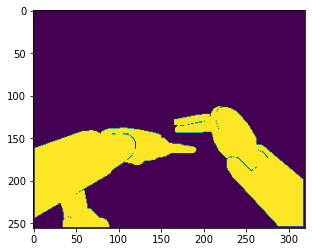

In [27]:
msk0 = mask.detach().cpu()
msk1 = msk0[0][0].permute(1,2,0)
plt.imshow(msk1>0)

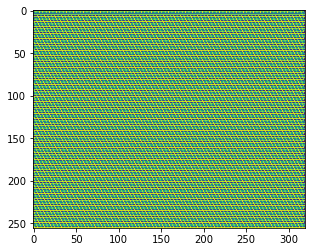

In [28]:
prd0 = pred.detach().cpu()
prd1 = prd0[0][0].permute(1,2,0)
plt.imshow(prd1)

In [84]:
inp = torch.randn(3, 5, requires_grad=True)
tar = torch.empty(3, dtype=torch.long).random_(5)
inp.shape, tar.shape

(torch.Size([3, 5]), torch.Size([3]))

In [85]:
pred.shape, mask.shape
pred = pred.unsqueeze(0)
mask = mask.unsqueeze(0)

In [ ]:
class LossBinary:
    """
    Loss defined as \alpha BCE - (1 - \alpha) SoftJaccard
    """

    def __init__(self, jaccard_weight=0):
        self.nll_loss = nn.BCEWithLogitsLoss()
        self.jaccard_weight = jaccard_weight

    def __call__(self, outputs, targets):
        loss = (1 - self.jaccard_weight) * self.nll_loss(outputs, targets)

        if self.jaccard_weight:
            eps = 1e-15
            jaccard_target = (targets == 1).float()
            jaccard_output = F.sigmoid(outputs)

            intersection = (jaccard_output * jaccard_target).sum()
            union = jaccard_output.sum() + jaccard_target.sum()

            loss -= self.jaccard_weight * torch.log((intersection + eps) / (union - intersection + eps))
        return loss

In [86]:
criterion = LossBinary(0.5)
loss = criterion(prd1.cuda(), msk1.cuda())
loss

tensor(1.4629, device='cuda:0')

In [87]:
msk1.count_nonzero()

tensor(11084)

In [88]:
msk1.shape

torch.Size([256, 320, 1])

In [89]:
256*320

81920